In [331]:
import pandas as pd
import numpy as np
import re
import commons as cmns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import Audio
sound_file = 'beep.wav'

In [332]:
data=pd.read_csv('all_BTC_Data.csv',sep=',')

In [333]:
data.shape

(2436, 738)

In [334]:
data.interpolate(axis=0,inplace=True)

C:\Users\13275\AppData\Local\Temp\ipykernel_41488\879274293.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data.interpolate(axis=0,inplace=True)


In [406]:
interval1 = (data['Date'] >= '2018/01/01') & (data['Date'] <= '2021/01/01')
interval2=(data['Date'] >= '2017/08/01') & (data['Date'] <= '2022/04/01')
interval3=(data['Date'] >= '2017/08/01') & (data['Date'] <= '2024/04/01')

In [407]:
data['one']=data['priceUSD'].shift(-1,fill_value=1)
seven=data['priceUSD'].shift(-7,fill_value=1)
fourteen=data['priceUSD'].shift(-14,fill_value=1)
thirty=data['priceUSD'].shift(-30,fill_value=1)
sixty=data['priceUSD'].shift(-60,fill_value=1)
ninety=data['priceUSD'].shift(-90,fill_value=1)

In [408]:
data['one']

0        2718
1        2747
2        2831
3        3152
4        3238
        ...  
2431    70055
2432    69970
2433    70429
2434    69724
2435        1
Name: one, Length: 2436, dtype: int64

In [409]:
interval1

0       False
1       False
2       False
3       False
4       False
        ...  
2431    False
2432    False
2433    False
2434    False
2435    False
Name: Date, Length: 2436, dtype: bool

In [410]:
df=data.loc[interval1]

In [411]:
#df['priceUSD']=one.loc[interval3]

In [412]:
df.shape

(1097, 739)

In [413]:
if 'one' in df.columns:
    # Create a new list of column names with 'one' as the third element
    # Grab the current list of columns
    cols = list(df.columns)
    # Remove 'one' from its current position
    cols.remove('one')
    # Insert 'one' at the second index (third position, since index starts at 0)
    cols.insert(2, 'one')
    # Reorder DataFrame according to the new list of columns
    df = df[cols]

In [414]:
from datetime import datetime

# Convert string to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Convert datetime to ordinal
df['Date'] = df['Date'].apply(lambda x: x.toordinal())

In [419]:
X_raw=df.iloc[:,4:19]

In [420]:
X_raw

,transactions,size,sentbyaddress,difficulty,hashrate,mining_profitability,sentinusdUSD,transactionfeesUSD,median_transaction_feeUSD,confirmationtime,transactionvalueUSD,mediantransactionvalueUSD,activeaddresses,top100cap,fee_to_rewardUSD
153,241601,966169,356264,1922580604981,1.504815e+19,2.174,13816700887,26.274,14.625,9.231,94104,2104.000,842391,18.038,19.412
154,340809,968332,527209,1931136454488,1.595798e+19,2.431,21724537648,26.522,12.574,8.421,103561,3921.000,982159,18.050,23.304
155,395806,975882,583433,1931136454488,1.489141e+19,2.737,21194139359,28.461,15.529,9.172,106867,4847.000,953442,18.092,27.649
156,424840,975713,653949,1931136454488,1.643691e+19,2.606,21932336721,27.264,15.519,8.571,95838,5033.000,1071574,18.021,27.047
157,342564,974894,563214,1931136454488,1.502404e+19,2.631,26876803227,32.515,17.298,10.070,135345,4727.000,951484,17.964,28.188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,308823,891069,538901,18600034145238,1.446115e+20,0.205,18788416695,8.696,4.390,9.000,172956,811.977,1013140,13.262,9.057
1246,336159,906078,581012,18599593048300,1.344655e+20,0.209,18964680930,8.401,4.387,9.474,146421,789.286,966765,13.261,10.029
1247,338086,881822,601557,18599593048300,1.611588e+20,0.206,20423990747,8.748,4.693,8.372,144967,836.243,1077900,13.237,8.914
1248,344752,897794,610371,18599593048300,1.496313e+20,0.222,19012516943,9.513,5.040,8.675,162863,751.424,1038604,13.220,9.871


In [421]:
y=df.iloc[:,3:4]
y

,priceUSD
153,13523
154,13924
155,15027
156,14883
157,15881
...,...
1245,26978
1246,26678
1247,28128
1248,28876


In [422]:
y=np.ravel(y)

In [423]:
y

array([13523, 13924, 15027, ..., 28128, 28876, 29260], dtype=int64)

In [424]:
features_list=[]
technical_indicators=['sma','ema','wma','trx','mom','std','var','rsi','roc']
periods=['3','7','14','30','90']
for i in technical_indicators:
    for j in periods:
        string=str(j)+str(i)
        X=df.filter(like=string,axis=1)
        X=SimpleImputer(missing_values=0,strategy='most_frequent').fit_transform(X)
        X=pd.DataFrame(X)
        X.columns=df.filter(like=string,axis=1).columns
        rf1=RandomForestRegressor(random_state=7,n_jobs=-1)
        rfecv=RFECV(rf1,step=0.9,min_features_to_select=1,verbose=1,cv=5,scoring='neg_mean_absolute_error', n_jobs=-1)
        rfecv.fit(X,y)
        if rfecv.n_features_>1:
            rf1.fit(X,y)
            maximp=rf1.feature_importances_.max()
            for x in range(len(rf1.feature_importances_)):
                if maximp==rf1.feature_importances_[x]:
                    new_features = X.columns[x]
        else:
            mask = rfecv.get_support()
            new_features = X.columns[mask]
        features_list.append(str(new_features))
        print(string+': '+new_features)


Fitting estimator with 16 features.
Fitting estimator with 2 features.
Index(['3sma: price3smaUSD'], dtype='object')
Fitting estimator with 16 features.
Fitting estimator with 2 features.
Index(['7sma: price7smaUSD'], dtype='object')
Fitting estimator with 16 features.
Fitting estimator with 2 features.
Index(['14sma: price14smaUSD'], dtype='object')
Fitting estimator with 16 features.
30sma: transactionvalue30smaUSD
Fitting estimator with 16 features.
90sma: top100cap90sma
Fitting estimator with 16 features.
Fitting estimator with 2 features.
Index(['3ema: price3emaUSD'], dtype='object')
Fitting estimator with 16 features.
Fitting estimator with 2 features.
Index(['7ema: price7emaUSD'], dtype='object')
Fitting estimator with 16 features.
Fitting estimator with 2 features.
Index(['14ema: price14emaUSD'], dtype='object')
Fitting estimator with 16 features.
30ema: price30emaUSD
90ema: transactionvalue90emaUSD
Fitting estimator with 16 features.
Fitting estimator with 2 features.
Index(['

In [425]:
#Audio(data=data, rate=44100, autoplay=True)

In [426]:
l1=[]
for j in range(len(features_list)):
    result1 = re.search("'(.*)'],", features_list[j])
    if result1!=None:
        l1.append(result1.group(1))
for i in range(len(features_list)):
    result2 = re.search('.*',features_list[i])
    if len(result2.group(0))<33:
        l1.append(result2.group(0))

In [427]:
l1.sort()

In [428]:
l1

['difficulty14roc',
 'difficulty14rsi',
 'difficulty30rsi',
 'difficulty3rsi',
 'difficulty3var',
 'difficulty7rsi',
 'hashrate90std',
 'hashrate90var',
 'median_transaction_fee3stdUSD',
 'median_transaction_fee7stdUSD',
 'median_transaction_fee7varUSD',
 'mediantransactionvalue90trxUSD',
 'mining_profitability30trx',
 'price14emaUSD',
 'price14momUSD',
 'price14smaUSD',
 'price14trxUSD',
 'price14wmaUSD',
 'price30emaUSD',
 'price30momUSD',
 'price30rocUSD',
 'price30wmaUSD',
 'price3emaUSD',
 'price3momUSD',
 'price3rocUSD',
 'price3smaUSD',
 'price3trxUSD',
 'price3wmaUSD',
 'price7emaUSD',
 'price7momUSD',
 'price7rocUSD',
 'price7smaUSD',
 'price7trxUSD',
 'price7wmaUSD',
 'price90momUSD',
 'price90rocUSD',
 'price90rsiUSD',
 'top100cap90sma',
 'transactionvalue14stdUSD',
 'transactionvalue14varUSD',
 'transactionvalue30smaUSD',
 'transactionvalue30stdUSD',
 'transactionvalue30varUSD',
 'transactionvalue90emaUSD',
 'transactionvalue90wmaUSD']

In [429]:
df_reduced=df[l1]

In [430]:
df_reduced.head()

,difficulty14roc,difficulty14rsi,difficulty30rsi,difficulty3rsi,difficulty3var,difficulty7rsi,hashrate90std,hashrate90var,median_transaction_fee3stdUSD,median_transaction_fee7stdUSD,...,price90rocUSD,price90rsiUSD,top100cap90sma,transactionvalue14stdUSD,transactionvalue14varUSD,transactionvalue30smaUSD,transactionvalue30stdUSD,transactionvalue30varUSD,transactionvalue90emaUSD,transactionvalue90wmaUSD
153,11.905,98.431,94.687,100.0,5.439530e+20,99.901,4.383382e+18,4.803510e+36,1.152,6.790,...,212.619,58.800,16.681,34611,299474155,102791,45479,517090770,79633,88769
154,3.098,98.501,94.804,100.0,6.542873e+20,99.911,4.483328e+18,5.025059e+36,2.312,6.889,...,226.612,59.312,16.695,34924,304912959,104246,42604,453769853,80158,89414
155,3.098,98.501,94.804,100.0,1.626724e+19,99.911,4.456041e+18,4.964074e+36,2.472,5.114,...,252.114,60.668,16.709,35309,311672785,105327,41142,423159610,80745,90113
156,3.098,98.501,94.804,100.0,-3.221225e+09,99.911,4.537494e+18,5.147212e+36,2.781,3.255,...,240.430,60.403,16.722,35003,306303138,105620,40741,414961219,81077,90549
157,3.098,98.501,94.804,100.0,-3.758096e+09,99.911,4.562248e+18,5.203527e+36,1.672,2.674,...,263.898,61.584,16.735,37247,346832482,106773,42061,442288548,82270,91836


In [431]:
X=cmns.drop_high_vif(df_reduced,thresh=5)

dropping 'hashrate90var' at index: 7
dropping 'transactionvalue30stdUSD' at index: 40
dropping 'transactionvalue14stdUSD' at index: 37
Remaining variables:
Index(['difficulty14roc', 'difficulty14rsi', 'difficulty30rsi',
       'difficulty3rsi', 'difficulty3var', 'difficulty7rsi', 'hashrate90std',
       'median_transaction_fee3stdUSD', 'median_transaction_fee7stdUSD',
       'median_transaction_fee7varUSD', 'mediantransactionvalue90trxUSD',
       'mining_profitability30trx', 'price14emaUSD', 'price14momUSD',
       'price14smaUSD', 'price14trxUSD', 'price14wmaUSD', 'price30emaUSD',
       'price30momUSD', 'price30rocUSD', 'price30wmaUSD', 'price3emaUSD',
       'price3momUSD', 'price3rocUSD', 'price3smaUSD', 'price3trxUSD',
       'price3wmaUSD', 'price7emaUSD', 'price7momUSD', 'price7rocUSD',
       'price7smaUSD', 'price7trxUSD', 'price7wmaUSD', 'price90momUSD',
       'price90rocUSD', 'price90rsiUSD', 'top100cap90sma',
       'transactionvalue14varUSD', 'transactionvalue30smaUSD',


In [432]:
X.shape

(1097, 42)

In [433]:
cmns.vif_values(X)

difficulty14roc                   0.927262
difficulty14rsi                   0.392264
difficulty30rsi                   0.316786
difficulty3rsi                    0.606514
difficulty3var                    1.015967
difficulty7rsi                    0.500960
hashrate90std                     0.190381
median_transaction_fee3stdUSD     1.080294
median_transaction_fee7stdUSD     1.036579
median_transaction_fee7varUSD     1.001619
mediantransactionvalue90trxUSD    1.014369
mining_profitability30trx         0.922107
price14emaUSD                     0.944845
price14momUSD                     1.043306
price14smaUSD                     0.942708
price14trxUSD                     1.020457
price14wmaUSD                     0.975834
price30emaUSD                     0.849011
price30momUSD                     1.048130
price30rocUSD                     1.032180
price30wmaUSD                     0.895224
price3emaUSD                      1.027377
price3momUSD                      1.012072
price3rocUS

In [434]:
Raw=cmns.drop_high_vif(X_raw,thresh=10)

dropping 'hashrate' at index: 4
dropping 'transactionfeesUSD' at index: 6
dropping 'difficulty' at index: 3
dropping 'sentbyaddress' at index: 2
dropping 'size' at index: 1
dropping 'top100cap' at index: 8
dropping 'activeaddresses' at index: 7
dropping 'confirmationtime' at index: 4
dropping 'mediantransactionvalueUSD' at index: 5
dropping 'median_transaction_feeUSD' at index: 3
Remaining variables:
Index(['transactions', 'mining_profitability', 'sentinusdUSD',
       'transactionvalueUSD', 'fee_to_rewardUSD'],
      dtype='object')


In [435]:
#cmns.vif_values(X_raw)
cmns.vif_values(Raw)

transactions            3.906274
mining_profitability    2.755510
sentinusdUSD            9.901287
transactionvalueUSD     2.933163
fee_to_rewardUSD        2.868985
dtype: float64

In [436]:
Raw['Date']=df['Date']

C:\Users\13275\AppData\Local\Temp\ipykernel_41488\415555305.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Raw['Date']=df['Date']


In [437]:
X['Date']=df['Date']

C:\Users\13275\AppData\Local\Temp\ipykernel_41488\3012381705.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Date']=df['Date']


In [439]:
X

,difficulty14roc,difficulty14rsi,difficulty30rsi,difficulty3rsi,difficulty3var,difficulty7rsi,hashrate90std,median_transaction_fee3stdUSD,median_transaction_fee7stdUSD,median_transaction_fee7varUSD,...,price90momUSD,price90rocUSD,price90rsiUSD,top100cap90sma,transactionvalue14varUSD,transactionvalue30smaUSD,transactionvalue30varUSD,transactionvalue90emaUSD,transactionvalue90wmaUSD,Date
153,11.905,98.431,94.687,100.000,5.439530e+20,99.901,4.383382e+18,1.152,6.790,11.525,...,9197.0,212.619,58.800,16.681,299474155,102791,517090770,79633,88769,736695
154,3.098,98.501,94.804,100.000,6.542873e+20,99.911,4.483328e+18,2.312,6.889,11.864,...,9661.0,226.612,59.312,16.695,304912959,104246,453769853,80158,89414,736696
155,3.098,98.501,94.804,100.000,1.626724e+19,99.911,4.456041e+18,2.472,5.114,6.539,...,10759.0,252.114,60.668,16.709,311672785,105327,423159610,80745,90113,736697
156,3.098,98.501,94.804,100.000,-3.221225e+09,99.911,4.537494e+18,2.781,3.255,2.648,...,10511.0,240.430,60.403,16.722,306303138,105620,414961219,81077,90549,736698
157,3.098,98.501,94.804,100.000,-3.758096e+09,99.911,4.562248e+18,1.672,2.674,1.787,...,11517.0,263.898,61.584,16.735,346832482,106773,442288548,82270,91836,736699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,-0.376,43.920,51.606,0.022,1.093075e+21,14.293,2.455630e+19,1.587,1.627,0.662,...,16242.0,151.283,73.702,13.587,855546192,130208,1299063836,117542,125500,737787
1246,-0.378,43.881,51.593,0.022,1.099993e+21,14.244,2.452093e+19,0.058,1.525,0.581,...,15927.0,148.141,72.855,13.577,809009206,132185,1241965557,118176,126184,737788
1247,-0.378,43.881,51.593,0.022,4.323616e+16,14.244,2.524531e+19,0.288,1.406,0.494,...,17363.0,161.279,74.298,13.566,808095223,131481,1208554544,118765,126819,737789
1248,-0.378,43.881,51.593,0.022,-8.933532e+11,14.244,2.545986e+19,0.533,1.382,0.478,...,18342.0,174.108,74.992,13.555,762373700,133341,1218032935,119734,127829,737790


In [440]:
df_merged=Raw.merge(X.drop_duplicates(subset='Date'),how='left')

In [441]:
df_merged.shape

(1097, 48)

In [442]:
df_merged.drop(columns='Date',inplace=True)

In [443]:
#df_merged['priceUSD']=np.ravel(y)

In [444]:
X=cmns.drop_high_vif(df_merged,thresh=10)

Remaining variables:
Index(['transactions', 'mining_profitability', 'sentinusdUSD',
       'transactionvalueUSD', 'fee_to_rewardUSD', 'difficulty14roc',
       'difficulty14rsi', 'difficulty30rsi', 'difficulty3rsi',
       'difficulty3var', 'difficulty7rsi', 'hashrate90std',
       'median_transaction_fee3stdUSD', 'median_transaction_fee7stdUSD',
       'median_transaction_fee7varUSD', 'mediantransactionvalue90trxUSD',
       'mining_profitability30trx', 'price14emaUSD', 'price14momUSD',
       'price14smaUSD', 'price14trxUSD', 'price14wmaUSD', 'price30emaUSD',
       'price30momUSD', 'price30rocUSD', 'price30wmaUSD', 'price3emaUSD',
       'price3momUSD', 'price3rocUSD', 'price3smaUSD', 'price3trxUSD',
       'price3wmaUSD', 'price7emaUSD', 'price7momUSD', 'price7rocUSD',
       'price7smaUSD', 'price7trxUSD', 'price7wmaUSD', 'price90momUSD',
       'price90rocUSD', 'price90rsiUSD', 'top100cap90sma',
       'transactionvalue14varUSD', 'transactionvalue30smaUSD',
       'transactionval

In [445]:
X.shape

(1097, 47)

In [446]:
cmns.vif_values(X)

transactions                      0.389869
mining_profitability              1.974942
sentinusdUSD                      0.731305
transactionvalueUSD               1.494693
fee_to_rewardUSD                  1.663056
difficulty14roc                   1.041687
difficulty14rsi                   0.521949
difficulty30rsi                   0.444300
difficulty3rsi                    0.704311
difficulty3var                    1.020205
difficulty7rsi                    0.620451
hashrate90std                     0.467839
median_transaction_fee3stdUSD     1.347901
median_transaction_fee7stdUSD     1.516512
median_transaction_fee7varUSD     1.225862
mediantransactionvalue90trxUSD    1.206361
mining_profitability30trx         0.947481
price14emaUSD                     2.820573
price14momUSD                     1.054152
price14smaUSD                     2.727148
price14trxUSD                     1.041490
price14wmaUSD                     2.865278
price30emaUSD                     2.441360
price30momU

In [447]:
if 'priceUSD' in X.columns:
    X.drop(columns='priceUSD',inplace=True)

In [448]:
rf_final=RandomForestRegressor(random_state=7,n_jobs=-1)

In [449]:
rf_final.fit(X,y)

RandomForestRegressor(n_jobs=-1, random_state=7)

In [450]:
imp_feat=cmns.feature_importance(X.columns,rf_final.feature_importances_)

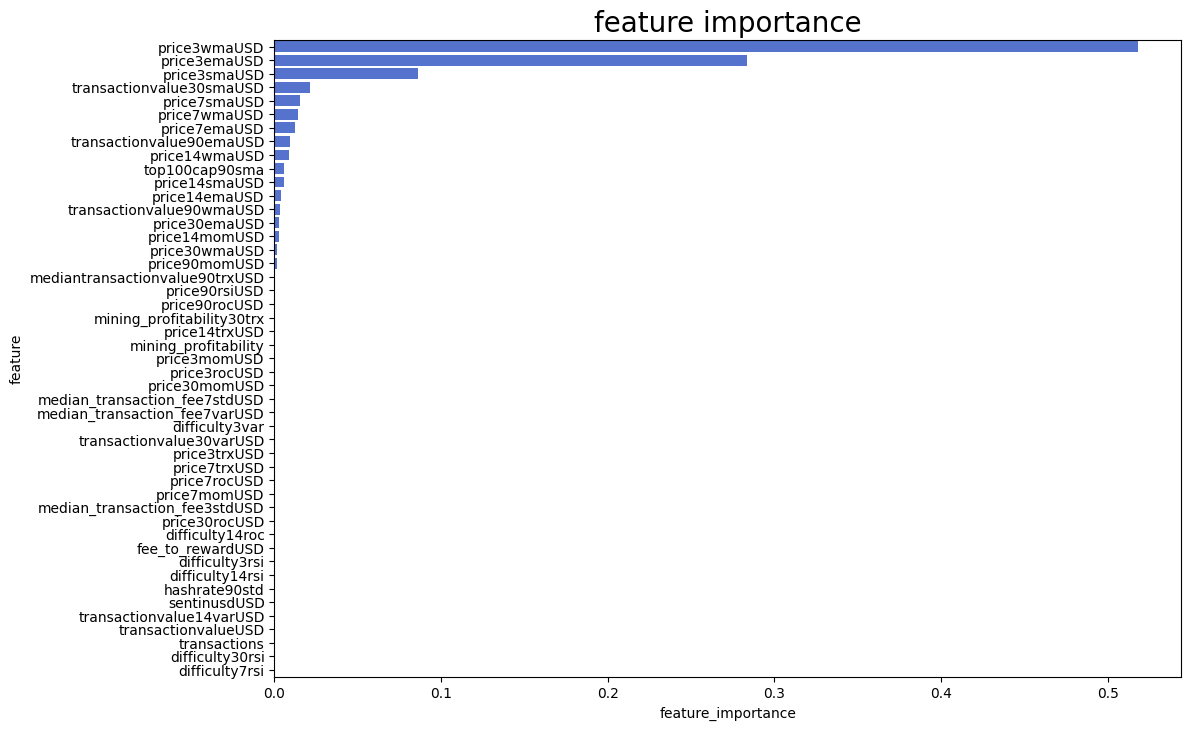

In [451]:
cmns.plot_feature_importance(imp_feat,'feature importance')

In [452]:
imp_feat[imp_feat['feature_importance']>0]


,feature,feature_importance
0,price3wmaUSD,0.518219
1,price3emaUSD,0.283514
2,price3smaUSD,0.086042
3,transactionvalue30smaUSD,0.021481
4,price7smaUSD,0.015525
5,price7wmaUSD,0.014050
6,price7emaUSD,0.012553
7,transactionvalue90emaUSD,0.009274
8,price14wmaUSD,0.008537
9,top100cap90sma,0.005839


In [459]:
cols=[0,3,5,4,7,8,9,13,16,17,20,28,37,40]

In [460]:
#selected=imp_feat[imp_feat['feature_importance']>0.001]
selected=imp_feat.filter(cols,axis=0)

In [461]:
selected

,feature,feature_importance
0,price3wmaUSD,0.518219
3,transactionvalue30smaUSD,0.021481
5,price7wmaUSD,0.014050
4,price7smaUSD,0.015525
7,transactionvalue90emaUSD,0.009274
8,price14wmaUSD,0.008537
9,top100cap90sma,0.005839
13,price30emaUSD,0.002557
16,price90momUSD,0.001673
17,mediantransactionvalue90trxUSD,0.000619


In [462]:
selected.feature_importance.sum()

0.5982506832604118

In [463]:
X_high=X[selected.feature]

In [464]:
X_high.shape

(1097, 14)

In [465]:
X_high.sort_index(axis=1,inplace=True)

C:\Users\13275\AppData\Local\Temp\ipykernel_41488\554794614.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_high.sort_index(axis=1,inplace=True)


In [466]:
X_high

,difficulty3var,fee_to_rewardUSD,hashrate90std,mediantransactionvalue90trxUSD,mining_profitability30trx,price14wmaUSD,price30emaUSD,price3wmaUSD,price7smaUSD,price7wmaUSD,price90momUSD,top100cap90sma,transactionvalue30smaUSD,transactionvalue90emaUSD
0,5.439530e+20,19.412,4.383382e+18,1.201,1.477,14301,14184,13442,14297,13911,9197.0,16.681,102791,79633
1,6.542873e+20,23.304,4.483328e+18,1.240,1.404,14174,14167,13703,14111,13818,9661.0,16.695,104246,80158
2,1.626724e+19,27.649,4.456041e+18,1.280,1.335,14237,14222,14408,14013,14047,10759.0,16.709,105327,80745
3,-3.221225e+09,27.047,4.537494e+18,1.322,1.268,14297,14265,14771,14091,14265,10511.0,16.722,105620,81077
4,-3.758096e+09,28.188,4.562248e+18,1.364,1.203,14505,14369,15406,14274,14712,11517.0,16.735,106773,82270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092,1.093075e+21,9.057,2.455630e+19,0.228,0.777,24441,21589,26718,24751,25488,16242.0,13.587,130208,117542
1093,1.099993e+21,10.029,2.452093e+19,0.229,0.804,24871,21917,26842,25265,25969,15927.0,13.577,132185,118176
1094,4.323616e+16,8.914,2.524531e+19,0.231,0.831,25425,22318,27453,25917,26685,17363.0,13.566,131481,118765
1095,-8.933532e+11,9.871,2.545986e+19,0.233,0.861,26001,22741,28261,26712,27425,18342.0,13.555,133341,119734


In [467]:
y

array([13523, 13924, 15027, ..., 28128, 28876, 29260], dtype=int64)

In [468]:
X_high['priceUSD']=np.ravel(y)

C:\Users\13275\AppData\Local\Temp\ipykernel_41488\2246101379.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_high['priceUSD']=np.ravel(y)


In [469]:
X_high

,difficulty3var,fee_to_rewardUSD,hashrate90std,mediantransactionvalue90trxUSD,mining_profitability30trx,price14wmaUSD,price30emaUSD,price3wmaUSD,price7smaUSD,price7wmaUSD,price90momUSD,top100cap90sma,transactionvalue30smaUSD,transactionvalue90emaUSD,priceUSD
0,5.439530e+20,19.412,4.383382e+18,1.201,1.477,14301,14184,13442,14297,13911,9197.0,16.681,102791,79633,13523
1,6.542873e+20,23.304,4.483328e+18,1.240,1.404,14174,14167,13703,14111,13818,9661.0,16.695,104246,80158,13924
2,1.626724e+19,27.649,4.456041e+18,1.280,1.335,14237,14222,14408,14013,14047,10759.0,16.709,105327,80745,15027
3,-3.221225e+09,27.047,4.537494e+18,1.322,1.268,14297,14265,14771,14091,14265,10511.0,16.722,105620,81077,14883
4,-3.758096e+09,28.188,4.562248e+18,1.364,1.203,14505,14369,15406,14274,14712,11517.0,16.735,106773,82270,15881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1092,1.093075e+21,9.057,2.455630e+19,0.228,0.777,24441,21589,26718,24751,25488,16242.0,13.587,130208,117542,26978
1093,1.099993e+21,10.029,2.452093e+19,0.229,0.804,24871,21917,26842,25265,25969,15927.0,13.577,132185,118176,26678
1094,4.323616e+16,8.914,2.524531e+19,0.231,0.831,25425,22318,27453,25917,26685,17363.0,13.566,131481,118765,28128
1095,-8.933532e+11,9.871,2.545986e+19,0.233,0.861,26001,22741,28261,26712,27425,18342.0,13.555,133341,119734,28876


<Axes: >

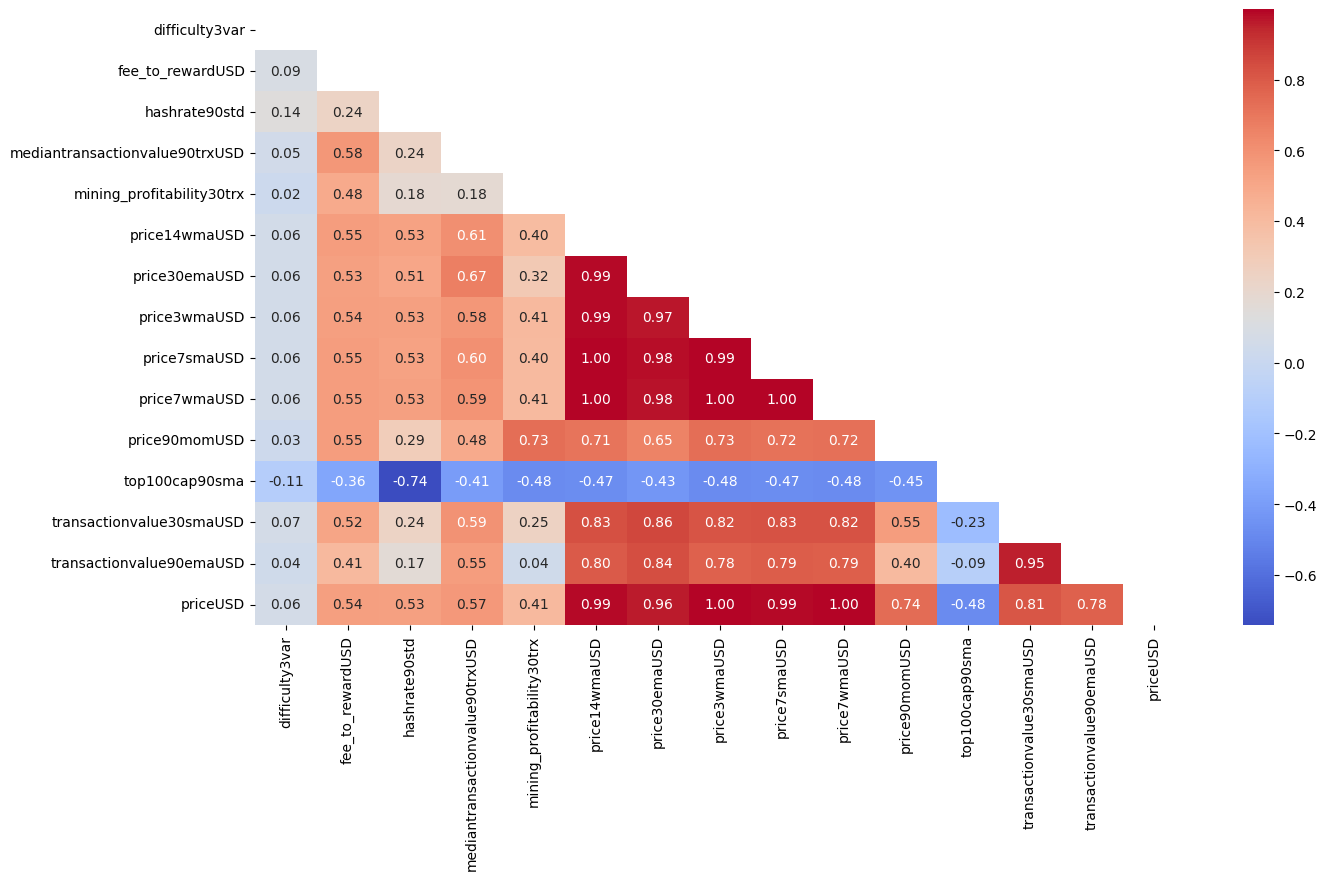

In [470]:
corr = X_high.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool_))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(corr,mask=mask, cmap='coolwarm',annot=True, fmt='.2f')

In [471]:
X_high=X_high[X_high['priceUSD']!=1]

In [472]:
from sklearn.ensemble import IsolationForest
outlier=IsolationForest(contamination=0.9)
price=X_high['priceUSD']
price=price.values
price=np.reshape(price,(-1,1))
outlier = IsolationForest(contamination='auto')
outlier.fit(price)
outs=outlier.predict(price)
X_high['outlier']=pd.DataFrame(zip(outs))
X_high=X_high.query('outlier != -1')
X_high.reset_index(drop=True,inplace=True)
X_high.drop(columns=['outlier'],inplace=True)

In [473]:
X_high.to_csv('reg_interval1.csv',sep=',',index=False)

In [474]:
X_high.columns

Index(['difficulty3var', 'fee_to_rewardUSD', 'hashrate90std',
       'mediantransactionvalue90trxUSD', 'mining_profitability30trx',
       'price14wmaUSD', 'price30emaUSD', 'price3wmaUSD', 'price7smaUSD',
       'price7wmaUSD', 'price90momUSD', 'top100cap90sma',
       'transactionvalue30smaUSD', 'transactionvalue90emaUSD', 'priceUSD'],
      dtype='object')

In [399]:
df1=pd.read_csv('reg_interval1.csv',sep=',')
date_range = pd.date_range(start='2018-01-01', end='2021-01-01', freq='D')



The date range does not match the number of rows in the DataFrame.
   fee_to_rewardUSD  price30wmaUSD  price3rocUSD  price7emaUSD  price7rocUSD  \
0            23.387          15333        -7.366         14061        -2.189   
1            24.447          15333        -7.366         14061        -2.189   
2            23.309          15333        -7.366         14061        -2.189   
3            12.818          15333        -7.366         14061        -2.189   
4            13.105          15333        -7.366         14061        -2.189   

   price7smaUSD  price7wmaUSD  price90rocUSD  price90rsiUSD  top100cap90ema  \
0         14297         13911        212.619           58.8          17.053   
1         14297         13911        212.619           58.8          17.053   
2         14297         13911        212.619           58.8          17.053   
3         14297         13911        212.619           58.8          17.053   
4         14297         13911        212.619           58

In [ ]:
'''# Check if the date range length matches the number of rows in the DataFrame
if len(date_range) == len(df1):
    df1['Date'] = date_range
else:
    print("The date range does not match the number of rows in the DataFrame.")
df1.to_csv('reg_interval2.csv',sep=',',index=False)
# Show the updated DataFrame
print(df1.head())'''